In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, GRU, Bidirectional, Flatten, Input, Attention
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
import joblib
from tqdm import tqdm

# Dataset Paths
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# Helper Functions
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate, alpha=0.8)
    plt.title(f"Waveplot for {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f"Spectrogram for {emotion}", size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def extract_features(data, sr):
    def compute_feature(func, *args, **kwargs):
        return np.mean(func(*args, **kwargs).T, axis=0)

    features = []
    features.append(compute_feature(librosa.feature.zero_crossing_rate, y=data))
    stft = np.abs(librosa.stft(data))
    features.append(compute_feature(librosa.feature.chroma_stft, S=stft, sr=sr))
    features.append(compute_feature(librosa.feature.mfcc, y=data, sr=sr))
    features.append(compute_feature(librosa.feature.rms, y=data))
    features.append(compute_feature(librosa.feature.melspectrogram, y=data, sr=sr))
    return np.hstack(features)

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    features = [extract_features(data, sample_rate)]
    features.append(extract_features(noise(data), sample_rate))
    features.append(extract_features(pitch(stretch(data), sample_rate), sample_rate))
    return np.vstack(features)

def load_and_process_data():
    ravdess_directory_list = os.listdir(Ravdess)
    file_emotion, file_path = [], []
    for dir in ravdess_directory_list:
        actor = os.listdir(Ravdess + dir)
        for file in actor:
            part = file.split('.')[0].split('-')
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
    Ravdess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})
    Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 
                                                              5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})

    crema_directory_list = os.listdir(Crema)
    file_emotion, file_path = [], []
    for file in crema_directory_list:
        part = file.split('_')
        file_path.append(Crema + file)
        file_emotion.append({'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
                             'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}.get(part[2], 'Unknown'))
    Crema_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

    tess_directory_list = os.listdir(Tess)
    file_emotion, file_path = [], []
    for dir in tess_directory_list:
        for file in os.listdir(Tess + dir):
            part = file.split('.')[0].split('_')[2]
            file_emotion.append('surprise' if part == 'ps' else part)
            file_path.append(Tess + dir + '/' + file)
    Tess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

    savee_directory_list = os.listdir(Savee)
    file_emotion, file_path = [], []
    for file in savee_directory_list:
        part = file.split('_')[1][:-6]
        file_path.append(Savee + file)
        file_emotion.append({'a': 'angry', 'd': 'disgust', 'f': 'fear', 
                             'h': 'happy', 'n': 'neutral', 'sa': 'sad'}.get(part, 'surprise'))
    Savee_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

    data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
    return data_path#.sample(n=1000)

def prepare_features_and_labels(data_path):
    print("Preparing Features and Labels from Dataset")
    X, Y = [], []
    for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path)):
        features = get_features(path)
        for feature in features:
            X.append(feature)
            Y.append(emotion)
    return np.array(X), np.array(Y)

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(128, kernel_size=5, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    query = Dense(64)(x)
    value = Dense(64)(x)
    attention_output = tf.keras.layers.Attention()([query, value])
    x = Flatten()(attention_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(8, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def perform_cross_validation(X, Y):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    best_model = None
    best_accuracy = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"Starting Fold {fold}")
        x_train, x_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]
        scaler = StandardScaler()
        x_train = np.expand_dims(scaler.fit_transform(x_train), axis=2)
        x_val = np.expand_dims(scaler.transform(x_val), axis=2)

        model = build_model((x_train.shape[1], x_train.shape[2]))
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=25, batch_size=64)

        val_accuracy = max(history.history['val_accuracy'])
        print(f"Fold {fold} Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_history = history

    print(f"Best model validation accuracy: {best_accuracy}")
    return best_model, best_history, scaler

def save_model_and_preprocessors(model, scaler, encoder):
    model.save('best_speech_emotion_model.h5')
    joblib.dump(scaler, 'best_scaler.save')
    joblib.dump(encoder, 'best_encoder.save')
    print("Model, scaler, and encoder saved successfully.")

def plot_metrics(history):
    epochs = range(len(history.history['accuracy']))
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')

    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')

    plt.show()

def calculate_average_audio_length(data_path):
    """
    Calculates the average length of audio files in the dataset.

    Parameters:
    - data_path: DataFrame containing file paths and corresponding emotions.

    Returns:
    - Average length of audio files in seconds.
    """
    total_length = 0
    num_files = len(data_path)

    for path in tqdm(data_path.Path, total=num_files, desc="Calculating audio lengths"):
        data, sample_rate = librosa.load(path, sr=None)  # Load full audio
        total_length += len(data) / sample_rate  # Convert samples to seconds

    average_length = total_length / num_files
    print(f"Average audio length: {average_length:.2f} seconds")
    return average_length

Calculating audio lengths: 100%|██████████| 12162/12162 [02:10<00:00, 93.18it/s] 


Average audio length: 2.62 seconds
Preparing Features and Labels from Dataset


 67%|██████▋   | 8114/12162 [32:43<14:18,  4.72it/s]  /opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 12162/12162 [46:38<00:00,  4.35it/s]


Starting Fold 1
Epoch 1/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.2981 - loss: 1.7456 - val_accuracy: 0.2991 - val_loss: 1.7177
Epoch 2/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4497 - loss: 1.3987 - val_accuracy: 0.4815 - val_loss: 1.2807
Epoch 3/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4757 - loss: 1.3129 - val_accuracy: 0.5380 - val_loss: 1.1807
Epoch 4/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4987 - loss: 1.2598 - val_accuracy: 0.5428 - val_loss: 1.1557
Epoch 5/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5233 - loss: 1.2055 - val_accuracy: 0.5558 - val_loss: 1.1262
Epoch 6/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5191 - loss: 1.2024 - val_accuracy: 0.5599 - val_loss: 1.1011
Epoch 7/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5360 - loss: 1.1700 - val_accuracy: 0.5622 - val_loss: 1.1117
Epoch 8/25
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5369 - loss: 

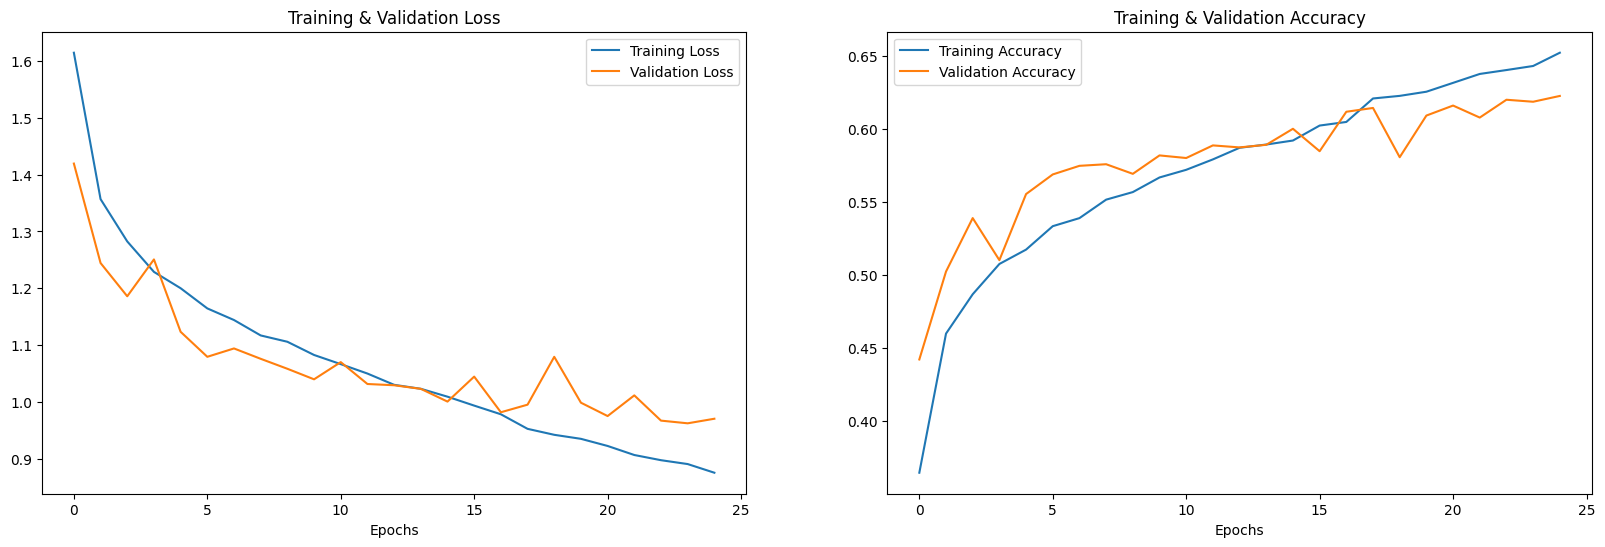

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Predicted Labels Actual Labels
0              sad       disgust
1          neutral       neutral
2             fear          fear
3            angry         angry
4            happy          fear
5              sad       disgust
6            angry         angry
7          disgust       disgust
8              sad       disgust
9          neutral       neutral


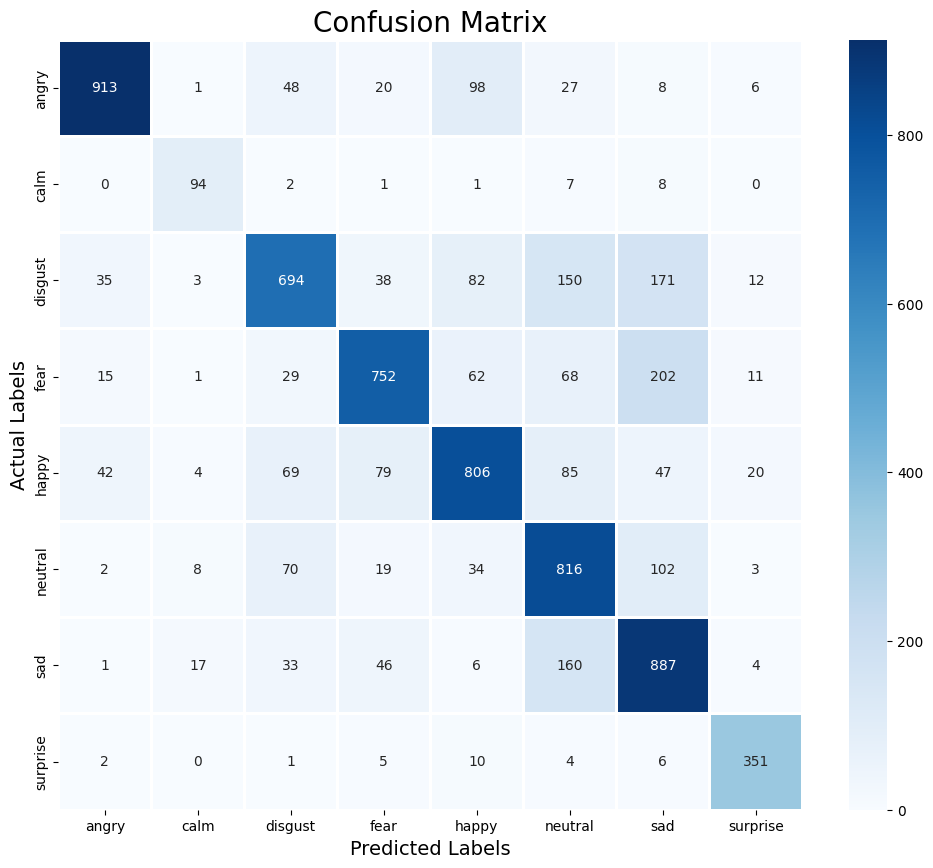

              precision    recall  f1-score   support

       angry       0.90      0.81      0.86      1121
        calm       0.73      0.83      0.78       113
     disgust       0.73      0.59      0.65      1185
        fear       0.78      0.66      0.72      1140
       happy       0.73      0.70      0.72      1152
     neutral       0.62      0.77      0.69      1054
         sad       0.62      0.77      0.69      1154
    surprise       0.86      0.93      0.89       379

    accuracy                           0.73      7298
   macro avg       0.75      0.76      0.75      7298
weighted avg       0.74      0.73      0.73      7298



In [4]:

# Main Execution
data_path = load_and_process_data()
average_length = calculate_average_audio_length(data_path)
X, Y = prepare_features_and_labels(data_path)
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

best_model, best_history, scaler = perform_cross_validation(X, Y_encoded)

x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = np.expand_dims(scaler.fit_transform(x_train), axis=2)
x_test = np.expand_dims(scaler.transform(x_test), axis=2)

print("Accuracy of our model on test data:", best_model.evaluate(x_test, y_test)[1] * 100, "%")

plot_metrics(best_history)

pred_test = best_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

results_df = pd.DataFrame({'Predicted Labels': y_pred.flatten(), 'Actual Labels': y_test.flatten()})
print(results_df.head(10))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linecolor='white', linewidths=1)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_test, y_pred))

In [5]:
save_model_and_preprocessors(best_model, scaler, encoder)

Model, scaler, and encoder saved successfully.
